# InsideAirbnb - London 

### Questions discussed in this report: 
1. Is Airbnb “out of control” in London?

2. How many professional landlords are there?

3. How many properties would be affected by the opposition’s proposal?
   - direct effects: illegal properties and professional properties + private room without presence of landlords
   - indirect effects: all properties
     
   (need to explain the mechanism of effect on properties in this question)

   - further: how would the effects be (discussed in question 4)
   - question: what kind of effects they could be? only negative or negative & positive?

4. What are the likely pros and cons of the opposition’s proposal? (for the Mayor, for the residents, for the city)

5. Can the story be reframed as a positive one about social mobility or housing opportunity?


## 1. EDA

### 1.0. Caching Remote Data

In [120]:
# Import libraries needed for this analysis
from pathlib import Path
from requests import get
from functools import wraps
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib
import matplotlib.font_manager

In [2]:
def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        url = Path(src) 
        fn  = url.name  
        dsn = Path(f"{dst}/{fn}") 
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create...
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

### 1.1. Data Loading

#### 1.1.0 Read Data

In this section, we read data remotely with the caching function above.

In [29]:
# Set download URL
ymd  = '20250615'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.csv.gz'

# Read csv data
df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,651 x 79


In [30]:
ddir  = Path('data/geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath + 'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath + 'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

+ data/geo/Boroughs.gpkg?raw=true found locally!
+ data/geo/Water.gpkg?raw=true found locally!
+ data/geo/Greenspace.gpkg?raw=true found locally!
Done.


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Boroughs.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Water.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Greenspace.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(


#### 1.1.1 Save Raw Data
Then, we want to save the raw Data in case we need them again in the later exploring.

In [31]:
# Create a diractory for raw data
path = Path(f'data/raw/{Path(url).name}') 
print(f"Writing to: {path}")

# Save raw data locally
if not path.parent.exists(): 
    print(f"Creating {path.parent}")
    path.parent.mkdir(parents=True, exist_ok=True)

if not path.exists():  
    df.to_csv(path, index=False)
    print("Done.")

Writing to: data/raw/20250615-London-listings.csv.gz


### 1.2 EDA - Data Processing

#### 1.2.0. Info

We run the chunk below to have a general sense of what are in the raw data, such as data type and columns.

In [32]:
# Get the information of the whole data set
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96651 entries, 0 to 96650
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            96651 non-null  int64  
 1   listing_url                                   96651 non-null  object 
 2   scrape_id                                     96651 non-null  int64  
 3   last_scraped                                  96651 non-null  object 
 4   source                                        96651 non-null  object 
 5   name                                          96651 non-null  object 
 6   description                                   93806 non-null  object 
 7   neighborhood_overview                         41983 non-null  object 
 8   picture_url                                   96642 non-null  object 
 9   host_id                                       96651 non-null 

In [33]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,9.665100e+04,9.665100e+04,9.665100e+04,96613.000000,96613.000000,0.0,96651.000000,96651.000000,96651.000000,62730.000000,...,71443.000000,71466.000000,71442.000000,71442.000000,0.0,96651.000000,96651.000000,96651.000000,96651.000000,71487.000000
mean,6.526020e+17,2.025061e+13,2.091790e+08,46.263577,76.334945,NaN,51.509818,-0.127087,3.316520,1.358018,...,4.792937,4.816368,4.733591,4.623804,NaN,16.389370,14.170831,2.164716,0.025763,0.958877
std,5.708808e+17,0.000000e+00,2.141266e+08,357.645418,561.614957,NaN,0.048945,0.100853,2.073674,0.725580,...,0.431668,0.423297,0.408804,0.506245,NaN,53.299577,52.845630,8.543681,0.626042,1.282595
min,1.391300e+04,2.025061e+13,2.594000e+03,1.000000,1.000000,NaN,51.295937,-0.496760,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.955518e+07,2.025061e+13,2.673176e+07,1.000000,1.000000,NaN,51.484240,-0.189060,2.000000,1.000000,...,4.760000,4.800000,4.650000,4.500000,NaN,1.000000,0.000000,0.000000,0.000000,0.150000
50%,8.123206e+17,2.025061e+13,1.128684e+08,2.000000,3.000000,NaN,51.513791,-0.126990,2.000000,1.000000,...,4.930000,4.970000,4.850000,4.750000,NaN,2.000000,1.000000,0.000000,0.000000,0.500000
75%,1.197378e+18,2.025061e+13,4.063762e+08,9.000000,14.000000,NaN,51.539099,-0.067880,4.000000,1.500000,...,5.000000,5.000000,5.000000,4.950000,NaN,8.000000,5.000000,1.000000,0.000000,1.230000
max,1.439673e+18,2.025061e+13,7.001298e+08,4884.000000,8723.000000,NaN,51.682630,0.278960,16.000000,26.000000,...,5.000000,5.000000,5.000000,5.000000,NaN,495.000000,495.000000,116.000000,25.000000,38.410000


#### 1.2.1. Columns

In [34]:
# Check columns in the data set
print(df.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

Given the result of columns above, we can tell there are many columns which are not useful for this analysis, therefore, we got `cols_selected` below by copying the output of (`df.columns.to_list()`) and then removing the fields that we thought we weren’t interested in.

In [35]:
cols_selected = ['id', 'listing_url', 'source', 'description', 'host_id', 'host_name', 'host_is_superhost',
                'host_listings_count', 'calculated_host_listings_count', 
                 'room_type', 'property_type','accommodates', 'bedrooms', 
                 'beds', 'price', 'minimum_nights','maximum_nights',
                'estimated_occupancy_l365d', 'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month',
                'review_scores_rating', 'latitude', 'longitude', 'neighbourhood_cleansed', 
                'host_total_listings_count', 'bathrooms', 'bathrooms_text', 
                'first_review', 'last_review']
len(cols_selected)

30

In [36]:
# Get a new df with selected cols
df = df[cols_selected]
print(f"The new data frame is {df.shape[0]:,} x {df.shape[1]}")

The new data frame is 96,651 x 30


#### 1.2.2. Dealing with NaNs and Nulls

Combined with results from `df.info()` and `df.describe()`, we see that a number of data types that aren’t ‘appropriate’ for their contents: the id columns are floats; the dates aren’t dates; there’s a boolean that’s not a boolean… It would be nice to fix these!

We started from exploring rows with NaN values. In the chunck below, we listed a exmaple from `price` columns. There are several more columns with the same issue, such `room_type` and `id`.

In [37]:
# Identify Problem Rows
df[df.price.isna()][['id','price','room_type']].head(3)

,id,price,room_type
12,271122,NaN,Private room
13,425143,NaN,Entire home/apt
16,427229,NaN,Private room


In [38]:
# There is no NaN in `id`
df[df.host_id.isna()][['id','host_id','price','room_type']]

,id,host_id,price,room_type


In [39]:
df[df.id.isna()][['id','price','room_type']]

,id,price,room_type


In [40]:
# Drop NaN
print(f"Data frame contains {df.shape[0]:,} rows.")
df.drop(df[df.host_id.isna()].index.array, axis=0, inplace=True)
print(f"Data frame contains {df.shape[0]:,} rows.")

Data frame contains 96,651 rows.
Data frame contains 96,651 rows.


We have checked there is no NaN values in `id` or in `host_id`, so we can now turn to counting NaNs or Nulls in the remaining data with a view to identifying other rows that can probably be dropped.

In [41]:
# returns a data frame with all values set to True/False according to Null status
df.isnull() 
# counts these values by column (we'll see another option in a moment)
df.isnull().sum(axis=0) 
# Sort results in `

#descending order
df.isnull().sum(axis=0).sort_values(ascending=False) 

beds                              33975
price                             33967
bathrooms                         33921
last_review                       25164
review_scores_rating              25164
reviews_per_month                 25164
first_review                      25164
bedrooms                          12580
description                        2845
host_is_superhost                  1823
bathrooms_text                      149
host_name                            40
host_listings_count                  38
host_total_listings_count            38
number_of_reviews_ltm                 0
neighbourhood_cleansed                0
longitude                             0
latitude                              0
id                                    0
number_of_reviews                     0
estimated_occupancy_l365d             0
maximum_nights                        0
listing_url                           0
accommodates                          0
property_type                         0


Based on the results above per column, it is sensible to retain all columns we selected.

In [42]:
# counting nulls by row
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

4622     11
3646     11
6122     11
5535     11
5155     11
187      10
232      10
683      10
82       10
35147    10
dtype: int64

<class 'pandas.core.series.Series'>


<Axes: ylabel='Frequency'>

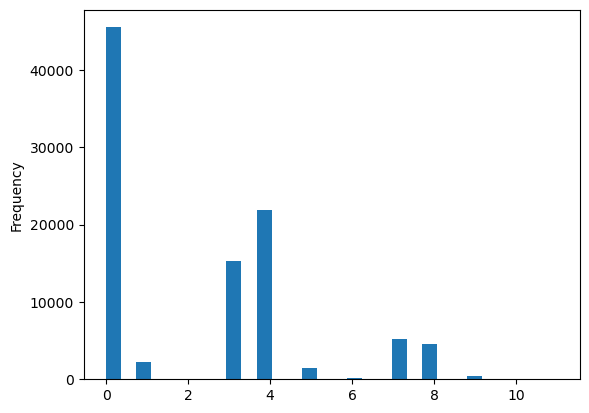

In [43]:
# save the results to a variable called probs
probs = df.isnull().sum(axis=1)
print(type(probs))       
probs.plot.hist(bins=30) 

The histogram shows that a significant proportion of data has zero or one missing value, while only a small number of rows have more than five missing values. It is therefore reasonable to retain all rows for further analysis.

#### 1.2.3. Fix Data Types

In this section, we are correcting data types that did not match the interpretation.

In [44]:
# Boolean
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost


In [45]:
# Date
dates = ['first_review','last_review']
print(f"Currently {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d])

print(f"Now {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")


Currently last_review is of type 'object' 

Converting first_review
Converting last_review
Now last_review is of type 'datetime64[ns]' 




source：
 source
city scrape        62816
previous scrape    33835
Name: count, dtype: int64
review_is_NULL：
first_review    25164
last_review     25164
dtype: int64


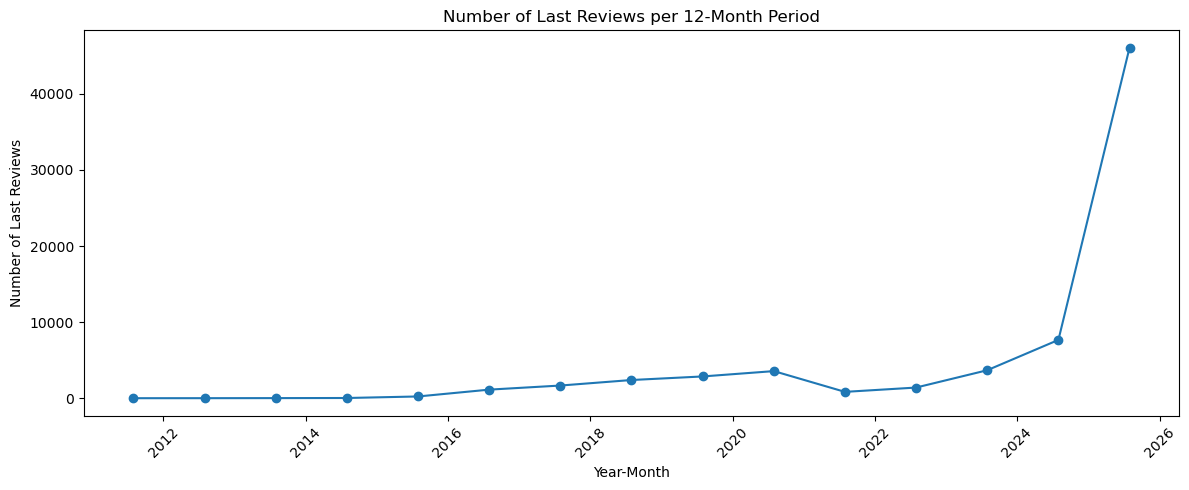

In [137]:
# year-number of last reviews,

source_counts = df['source'].value_counts()
print("\nsource：\n", source_counts)

review_cols = ['first_review', 'last_review']
na_counts = df[review_cols].isna().sum()

print("review_is_NULL：")
print(na_counts)

import matplotlib.pyplot as plt

monthly_counts = df.set_index('last_review').resample('12ME').size()

plt.figure(figsize=(12,5))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Number of Last Reviews')
plt.title('Number of Last Reviews per 12-Month Period')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [138]:
# counting review_time percentage
# validate active listings

now = pd.Timestamp('2025-06-15')
windows = [12, 24, 36, 48, 60, 72, 84]  

reviewed_listings = df[df['last_review'].notna()]
total_reviewed = reviewed_listings.shape[0]

print(f"listings_have_reviews: {total_reviewed}")
for w in windows:
    cutoff = now - pd.DateOffset(months=w)
    active_count = reviewed_listings[reviewed_listings['last_review'] >= cutoff].shape[0]
    active_ratio = active_count / total_reviewed * 100
    print(f"active last {w} month: {active_count}/{total_reviewed} → {active_ratio:.2f}%")


no_review_listings1 = df[df['last_review'].isna() & (df['number_of_reviews'].isna() | (df['number_of_reviews'] == 0))]
no_review_listings2 = df[df['last_review'].isna() & (df['number_of_reviews_ltm'].isna() | (df['number_of_reviews_ltm'] == 0))]
len(no_review_listings1)
len(no_review_listings2)

print("Listings with no first/last review = 0 reviews")
print("Only select out active listings (can be down later)")
# Listings with no first/last review = 0 reviews
# Only select out active listings (can be down later)

listings_have_reviews: 71487
active last 12 month: 48259/71487 → 67.51%
active last 24 month: 54758/71487 → 76.60%
active last 36 month: 57759/71487 → 80.80%
active last 48 month: 58889/71487 → 82.38%
active last 60 month: 59665/71487 → 83.46%
active last 72 month: 63751/71487 → 89.18%
active last 84 month: 66451/71487 → 92.96%
Listings with no first/last review = 0 reviews
Only select out active listings (can be down later)


In [48]:
# categories
cats = ['property_type','room_type']
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")

Currently room_type is of type 'object' 

Converting property_type
Converting room_type
Currently room_type is of type 'category' 



In [51]:
# strings
money = ['price']
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


### JL - convert `bathroom_text` into integer 

In [52]:
# string

df["bathrooms_text"].unique()
df["bathrooms_text"] = df["bathrooms_text"].replace({
    "Shared half-bath": "0.5 shared baths",
    "Half-bath": "0.5 baths",
    "Private half-bath": "0.5 baths"
})

df["bathrooms_text"] = df["bathrooms_text"].astype(str)

df["bathrooms_text"] = (
    df["bathrooms_text"]
        .str.split(" ", n=1).str[0]
        .astype(float)
)

print("bathrooms null:", df["bathrooms"].isnull().sum())
print("bathrooms_text null:", df["bathrooms_text"].isnull().sum())

df = df.drop(columns=['bathrooms'])
df.rename(columns={'bathrooms_text': 'bathroom_new'}, inplace=True)

# bathrooms null: 33921
# bathrooms_text null: 149
# col "bathrooms_text" have more valid values

bathrooms null: 33921
bathrooms_text null: 149


After investigation from the metadata, we know that both `bathrooms` and `bathrooms_text` representing the same idea of a listing, while the only difference is the format. For `bathrooms` column, we have a column of numeric data while we have a text data for `bathrooms_text`. After extracting the number of bathrooms from `bathrooms_text`, we have a new column, and under the comparison with `bathrooms`, we notice there are more null values in the column of `bathrooms`. Therefore, we drop the `bathrooms` and keep the new column we created.

`host_listings_count`: The number of listings the host has in total on the Airbnb platform (may include other cities). **This is the host-provided value.**

`host_total_listings_count`: The total number of listings the host manages globally.

`calculated_host_listings_count`: The number of listings the host manages in the current city/area of the dataset (e.g., only London). This value is calculated by the scraper, not provided by the host.

`Accomoundates`: The maximum number of guests the listing is advertised to sleep.

For the Question 2 about the professional landlord, we're mainly interested about `calculated_host_listings_count`.

In [55]:
# col types
ints = ['id', 'host_id',
        'host_listings_count', 
        'accommodates', 'bedrooms', 'beds', 'minimum_nights','maximum_nights',
        'estimated_occupancy_l365d', 'number_of_reviews_ltm', 'reviews_per_month',
        'host_total_listings_count', 'bathroom_new', 'calculated_host_listings_count']

print(df[ints].dtypes)

id                                  int64
host_id                             int64
host_listings_count               float64
accommodates                        int64
bedrooms                          float64
beds                              float64
minimum_nights                      int64
maximum_nights                      int64
estimated_occupancy_l365d           int64
number_of_reviews_ltm               int64
reviews_per_month                 float64
host_total_listings_count         float64
bathroom_new                      float64
calculated_host_listings_count      int64
dtype: object


In [60]:
# # dealing with NULL/NAN/"" in numeric col
# # transforming int type to UInt16(An extended form of int, allow keeping NULL)

# int_cols = [col for col in df.columns if str(df[col].dtype).startswith(('int', 'UInt'))]

# na_report = df[int_cols].isna().sum()

# print("number of NULL rows：")
# print(na_report)

# cols_with_nulls = ["host_listings_count", "bedrooms", "beds"]

# for col in cols_with_nulls:
#     df[col] = df[col].astype("UInt16") 

### 1.3 Saving Clean Data

In [56]:
csv_out = Path(f'data/clean/{path.name}')
pq_out  = Path(f'data/clean/{path.name.replace('.csv.gz','.parquet')}')

if not csv_out.parent.exists():
    print(f"Creating {csv_out.parent}")
    csv_out.parent.mkdir(parents=True, exist_ok=True)
    
df.to_csv(csv_out, index=False)
df.to_parquet(pq_out, index=False)
print(f"Saved {df.shape[0]:,} rows of {df.shape[1]:,} columns to {csv_out.resolve()}")
print("Done.")

Saved 96,651 rows of 29 columns to /home/jovyan/work/data/clean/20250615-London-listings.csv.gz
Done.


#### Data filtering
JL 

last_review，一年/两年数量对比，选择肘点

### Question 2: Professional Landlords

Strategy:

1. group_by `host_id`
2. sum the count of listings manually
3. compare the sum result with `calculated_host_listings_count` to check the accuracy
4. filter by `room_type`

**Rationale for Professional Classification**

The goal of classifying a host as "professional" is to identify businesses focused on commercial short-term rental income rather than casual income from spare space. It is robust to combine the concepts of Scale (number of listings) and Intent (room type) to classify a professional landlord.

1. Criterion 1: Scale (Quantity)
   - Metric Used: `calculated_host_listings_count` (manual verification needed).
   - Threshold: $\geq 2$ listings.
   - Justification: A host with only one listing could still be commercial, but having two or more listings is the most reliable threshold for establishing a commercial operation. A host renting out multiple separate units is primarily driven by business expansion and investment, not by sharing their primary residence.
   
2. Criterion 2: Intent (Nature)
   - Metric Used: `room_type`
     
   - Categories Selected: Entire home/apt and Hotel room
  
     
   - Justification: This filters the type of housing being rented, distinguishing between sharing a residence and fully commercializing a property:
       - Entire home/apt: Signals the host has completely separated the rental unit from their own residence. This is a dedicated income-generating asset and represents the conversion of residential stock.
       - Hotel room: Explicitly signals the listing is part of the established, professional hospitality industry.
       - Exclusion of Private/Shared rooms: These types are excluded because they suggest the host lives on-site (or is sharing a single unit), which aligns closer to the original sharing economy model. However, we will still analyse from `description` and `review` to make sure these rooms are not shared with guests only (i.e. presence of landlords).

To classify a listing as belonging to a **"Professional Landlord,"** it must satisfy Criterion 1 (Scale) AND its `room_type` must be one of the types selected by Criterion 2 (Intent).

In [104]:
# group by `host_id`

# if the listings >1: then we assume they are pro (literature review)
# we will have a look at the distribution of these >=2 listings 
df['listing_count'] = df.groupby('host_id')['id'].transform('count')
## Filter df to keep only hosts with 2 or more listings
df_multi_host = df[df['listing_count'] > 1].copy()

## Filter df to keep hosts with one listing
df_single_host = df[df['listing_count'] == 1].copy()

col_landlord = ['host_id', 'id', 'room_type', 'property_type', 'listing_count', 
                'calculated_host_listings_count', 'description']
df_multi_host = df_multi_host[col_landlord]
df_single_host = df_single_host[col_landlord]

**Accuracy in `calculated_host_listings_count`**

We firstly compare if the numbers in column `listing_count` are exactly the same as numbers in column `calculated_host_listings_count`. If we check the accuracy of `calculated_host_listings_count`, we can directly use this column for further analysis.

In [105]:
df_multi_host['is_match'] = df_multi_host['listing_count'] == df_multi_host['calculated_host_listings_count']
num_matches = df_multi_host['is_match'].sum()
total_length = len(df_multi_host)
num_mismatches = total_length - num_matches
print(f"Number of mismatches (discrepancies) in multi-listing hosts: {num_mismatches:,}")

Number of mismatches (discrepancies) in multi-listing hosts: 0


In [106]:
df_single_host['is_match'] = df_single_host['listing_count'] == df_single_host['calculated_host_listings_count']
num_matches = df_single_host['is_match'].sum()
total_length = len(df_single_host)
num_mismatches = total_length - num_matches
print(f"Number of mismatches (discrepancies) in single-listing hosts: {num_mismatches:,}")

Number of mismatches (discrepancies) in single-listing hosts: 0


So far, we have verified the accuracy of column `calculated_host_listings_count`. 

Then we can filter the `room_type` (and `property_type`) for further analysis. The `room_type` column directly addresses the commercial intent by defining the relationship between the host and the listing. We are less instrested in `property_type`, because it describes the physical characteristics of the building, which has little bearing on the host's business model.

Our analysis is below:

1. **Entire home/apt** has high likelihood of professionalism, because this means the host is renting out an entire, separate unit. If a host has multiple "Entire home/apt" listings, they are almost certainly a professional operator, as they are not living in any of the units and are solely focused on commercial rental income.

2. **Private room** has lower likelihood (usually). This often implies a host lives on-site and is renting out a spare bedroom, which is closer to the original, non-commercial ethos of Airbnb. While some professional operators manage multiple private rooms within a single large property, the classification itself is a much softer signal than "Entire home/apt." We will explore this case later in this section.

3. **Shared room** can be regarded as hostel/budget operator. This usually indicates a commercial hostel or a very budget-focused operator.

Room Type Distribution (Counts):
 room_type
Entire home/apt    34206
Private room       17214
Shared room          152
Hotel room           103
Name: count, dtype: int64

Bar chart saved as room_type_distribution_bar_chart.png


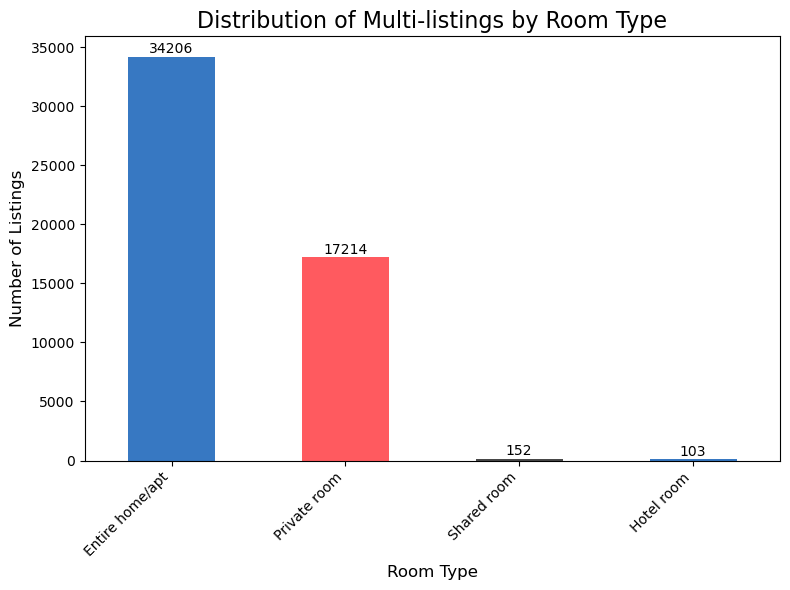

In [107]:
# multi-listing host
room_type_counts = df_multi_host['room_type'].value_counts()
plt.figure(figsize=(8, 6))
room_type_counts.sort_values(ascending=False).plot(kind='bar', color=['#3778c2', '#ff5a5f', '#484848'])
# Add title and labels
plt.title('Distribution of Multi-listings by Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the counts on top of the bars for exact values
for i, count in enumerate(room_type_counts.sort_values(ascending=False)):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()

# Save the plot
#plt.savefig('room_type_distribution_bar_chart.png')
#plt.close()

print("Room Type Distribution (Counts):\n", room_type_counts)
print("\nBar chart saved as room_type_distribution_bar_chart.png")

In [101]:
# Calculate the raw counts of each room_type in the multi-host group
room_type_counts = df_multi_host['room_type'].value_counts()

# Calculate the percentage distribution
# normalize=True makes the result a percentage (sum of 1.0)
room_type_percentages = df_multi_host['room_type'].value_counts(normalize=True) * 100

print("--- Room Type Distribution for Multi-Listing Landlords ---")
print("\n1. Raw Counts:")
print(room_type_counts)
print("\n2. Percentage Distribution:")
print(room_type_percentages.round(2).astype(str) + '%')

--- Room Type Distribution for Multi-Listing Landlords ---

1. Raw Counts:
room_type
Entire home/apt    34206
Private room       17214
Shared room          152
Hotel room           103
Name: count, dtype: int64

2. Percentage Distribution:
room_type
Entire home/apt    66.19%
Private room       33.31%
Shared room         0.29%
Hotel room           0.2%
Name: proportion, dtype: object


Our main concern is how to define the identification of host with multiple private rooms or shared rooms. Are they professional landlords?

To robust our analysis, we take further step to investigate the `description`. Under the comparision wiht "Entire home/apt" and "Hotel room", we want to know if there are many similar descriptions from "Private room", "Shared room", which indicats commercial usage.

In [132]:
# ### text analysis
# '''
# tried to use this code, but failed
# '''
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# df['description'] = df['description'].fillna('')

# # --- 1. SEGMENTATION & VECTORIZATION ---

# # Create masks for the three groups we want to compare
# is_entire = (df['room_type'] == 'Entire home/apt')
# is_private = (df['room_type'] == 'Private room')
# is_shared = (df['room_type'] == 'Shared room')
# is_candidate = is_private | is_shared

# # 1.1. Prepare the descriptions for vectorization
# # We must vectorize the entire dataset together to ensure a consistent feature set (vocabulary).
# all_descriptions = df['description'].tolist()

# # 1.2. Initialize and fit the vectorizer
# vectorizer = TfidfVectorizer(
#     stop_words='english',
#     max_features=2000,     # Increased features for better language nuance
#     ngram_range=(1, 2)
# )

# # Fit the vectorizer and transform ALL descriptions into the TF-IDF matrix
# tfidf_matrix = vectorizer.fit_transform(all_descriptions)


# # --- 2. CALCULATE THE REFERENCE PROFILE (Entire Home) ---

# # 2.1. Extract vectors for Entire Home listings
# entire_vectors = tfidf_matrix[is_entire.values]

# # 2.2. Calculate the average vector for the Entire Home group
# # This is the "average commercial language profile"
# entire_reference_vector = entire_vectors.mean(axis=0)
# entire_reference_vector_dense = entire_reference_vector.getA().flatten()


# # --- 3. CALCULATE SIMILARITY FOR CANDIDATE LISTINGS ---

# # 3.1. Extract vectors for the Private/Shared candidate listings
# candidate_vectors = tfidf_matrix[is_candidate]

# # 3.2. Get the host IDs for matching the scores back to the original DataFrame
# candidate_indices = df[is_candidate].index

# # 3.3. Calculate Cosine Similarity:
# # We compare every candidate vector (row in candidate_vectors) against the single reference vector.
# similarity_scores = cosine_similarity(candidate_vectors, entire_reference_vector)

# # Flatten the result and map it back to the DataFrame
# similarity_series = pd.Series(similarity_scores.flatten(), index=candidate_indices)
# df['entire_similarity_score'] = 0.0 # Initialize column

# df.loc[candidate_indices, 'entire_similarity_score'] = similarity_series

# # --- 4. APPLY THRESHOLD & RECLASSIFY ---

# # **CRITICAL DECISION:** You must choose a threshold. A good starting point is the 90th percentile
# # of similarity scores among the Private/Shared listings.
# similarity_threshold = df.loc[is_candidate, 'entire_similarity_score'].quantile(0.90)

# print(f"Similarity Threshold for Commercial Classification (90th percentile): {similarity_threshold:.4f}")

# # Flag listings with high similarity as linguistically commercial
# is_ling_commercial = df['entire_similarity_score'] >= similarity_threshold


# # --- 5. RECALCULATE PROFESSIONAL LANDLORDS ---

# # A. Base Commercial (Intent & Scale)
# is_entire_multi = (df['room_type'] == 'Entire home/apt') & (df['listing_count'] > 1)
# is_hotel = (df['room_type'] == 'Hotel room')

# # B. Refined Professional Filter: Add the high-similarity shared units
# is_professional_listing_refined = is_entire_multi | is_hotel | is_ling_commercial

# # Filter and count
# df_landlord_refined = df[is_professional_listing_refined].copy()
# num_landlords_refined = df_landlord_refined['host_id'].nunique()
# num_properties_refined = df_landlord_refined.shape[0]

# print("\n--- Final Refined Professional Landlord Count ---")
# print(f"Total Unique Professional Landlords: {num_landlords_refined:,}")
# print(f"Total Properties Managed by Refined Definition: {num_properties_refined:,}")
# print(f"Number of Private/Shared Listings added via Similarity: {is_ling_commercial.sum():,}")

Room Type Distribution (Counts):
 room_type
Entire home/apt    28250
Private room       16679
Shared room           39
Hotel room             8
Name: count, dtype: int64

Bar chart saved as room_type_distribution_bar_chart.png


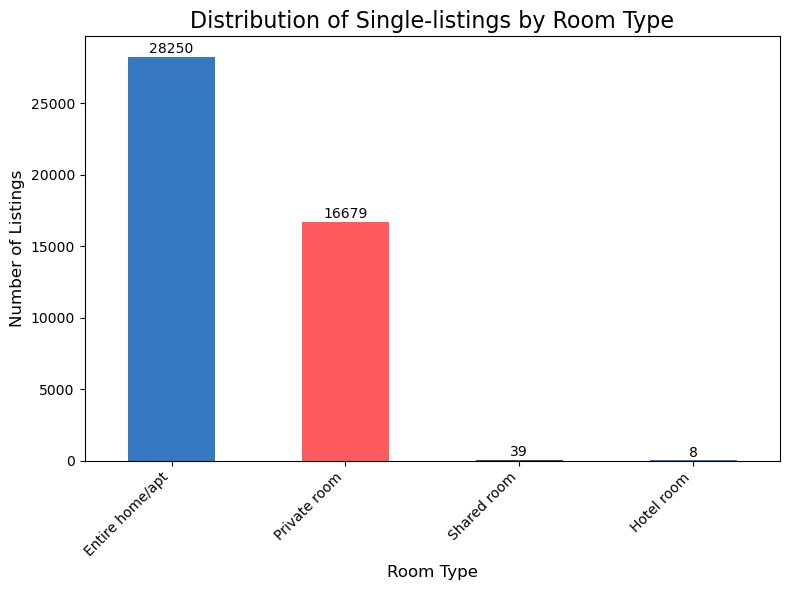

In [99]:
# single-listing host
room_type_counts = df_single_host['room_type'].value_counts()
plt.figure(figsize=(8, 6))
room_type_counts.sort_values(ascending=False).plot(kind='bar', color=['#3778c2', '#ff5a5f', '#484848'])
# Add title and labels
plt.title('Distribution of Single-listings by Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the counts on top of the bars for exact values
for i, count in enumerate(room_type_counts.sort_values(ascending=False)):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()

# Save the plot
#plt.savefig('room_type_distribution_bar_chart.png')
#plt.close()

print("Room Type Distribution (Counts):\n", room_type_counts)
print("\nBar chart saved as room_type_distribution_bar_chart.png")

In [136]:
# Calculate the raw counts of each room_type in the single-host group
room_type_counts = df_single_host['room_type'].value_counts()

# Calculate the percentage distribution
# normalize=True makes the result a percentage (sum of 1.0)
room_type_percentages = df_single_host['room_type'].value_counts(normalize=True) * 100

print("--- Room Type Distribution for Single-Listing Landlords ---")
print("\n1. Raw Counts:")
print(room_type_counts)
print("\n2. Percentage Distribution:")
print(room_type_percentages.round(2).astype(str) + '%')

--- Room Type Distribution for Single-Listing Landlords ---

1. Raw Counts:
room_type
Entire home/apt    28250
Private room       16679
Shared room           39
Hotel room             8
Name: count, dtype: int64

2. Percentage Distribution:
room_type
Entire home/apt    62.81%
Private room       37.08%
Shared room         0.09%
Hotel room          0.02%
Name: proportion, dtype: object


From plot and data results, we know there are 62.8% of single-listing is "Entire home/apt". This indicates a large propotion of a single "Entire home/apt" listing, which we could not ignore in terms of "professional property".

Based on analysis so far, we adjust our criteria as: a **"Professional Landlord,"** it must satisfy Criterion 1 (Scale) with new threshold of  `listing_count` $\geq 1$ AND its `room_type` must be one of the types selected by Criterion 2 (Intent).

--- 1. Professional Landlord Analysis ---
Total Unique Landlords: 55,804
Total number of Professional Landlords (Unique Host IDs): 7,703
Total number of Properties managed by these landlords: 62,567
Percentage of Professional Landlords: 64.43%
Percentage of Professional Properties: 64.73%

--- 2. Segmentation Summary ---
Total Multi-Host Listings (df_multi_host): 51,675
Total Single-Host Listings (df_single_host): 44,976


<Figure size 1000x600 with 0 Axes>

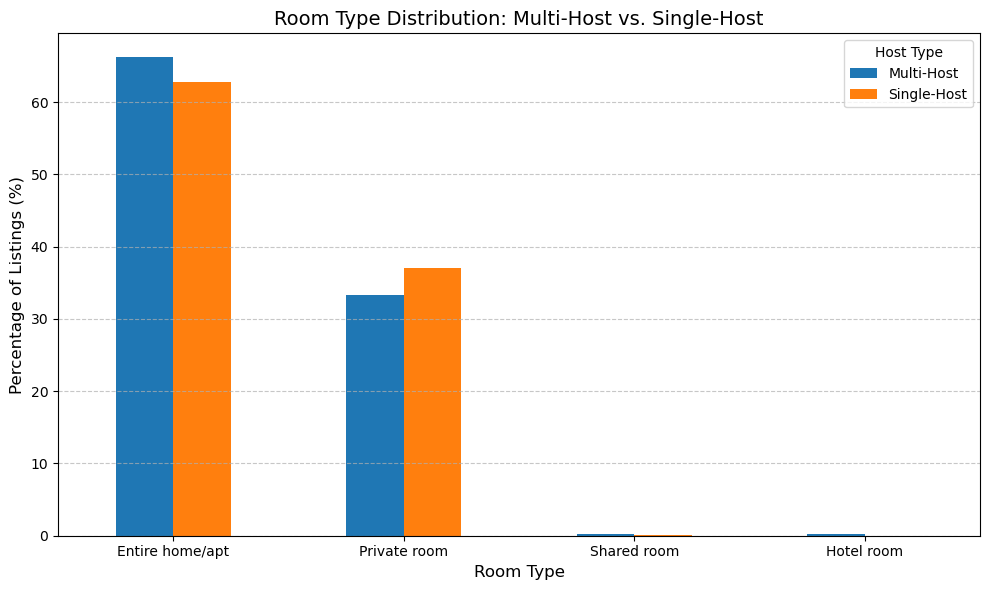


--- 3. Distribution Comparison (Percentage) ---
                 Multi-Host  Single-Host
room_type                               
Entire home/apt   66.194485    62.811277
Private room      33.312046    37.084223
Shared room        0.294146     0.086713
Hotel room         0.199323     0.017787


In [137]:
# Define the columns we'll be interested in throughout the analysis
COLUMNS_OF_INTEREST = [
    'host_id', 'id', 'room_type', 'property_type', 
    'listing_count', 'calculated_host_listings_count'
]

## --- STAGE 1: CLASSIFICATION AND SEGMENTATION ---

# 1. Calculate Scale: Determine how many listings each host has in the dataset.
df['listing_count'] = df.groupby('host_id')['id'].transform('count')

# 2. Define the Professional Landlord Criteria (Intent and Scale)
is_entire_multi = (df['room_type'] == 'Entire home/apt') & (df['listing_count'] >= 1)
is_hotel = (df['room_type'] == 'Hotel room')
df['is_professional_listing'] = is_entire_multi | is_hotel


# --- 2.1. Create the Final Professional Landlord DF (df_landlord) ---

# Filter the main DF to keep ONLY the professional listings and select columns
df_professional = df[df['is_professional_listing']].copy()
df_landlord = df_professional[COLUMNS_OF_INTEREST]

# --- 2.2. Create Multi/Single Host DFs for Distribution Analysis ---

# Filter for Multi-Host Listings (Scale > 1)
df_multi_host = df[df['listing_count'] > 1].copy()
df_multi_host = df_multi_host[COLUMNS_OF_INTEREST]

# Filter for Single-Host Listings (Scale = 1)
df_single_host = df[df['listing_count'] == 1].copy()
df_single_host = df_single_host[COLUMNS_OF_INTEREST]


# --- STAGE 2: CALCULATION AND ANALYSIS ---

total_landlords = df['host_id'].nunique()
total_property = df.shape[0]

# 3. Final Calculation for Professional Landlords
num_professional_landlords = df_landlord['host_id'].nunique()
num_properties = df_landlord.shape[0]

if total_landlords > 0:
    professional_percentage = (num_professional_landlords / total_landlords) * 100
else:
    professional_percentage = 0.0

pro_property_percentage = (num_properties / total_property)*100

print("--- 1. Professional Landlord Analysis ---")
print(f"Total Unique Landlords: {total_landlords:,}")
print(f"Total number of Professional Landlords (Unique Host IDs): {num_landlords:,}")
print(f"Total number of Properties managed by these landlords: {num_properties:,}")
print(f"Percentage of Professional Landlords: {professional_percentage:.2f}%")
print(f"Percentage of Professional Properties: {pro_property_percentage:.2f}%")

print("\n--- 2. Segmentation Summary ---")
print(f"Total Multi-Host Listings (df_multi_host): {df_multi_host.shape[0]:,}")
print(f"Total Single-Host Listings (df_single_host): {df_single_host.shape[0]:,}")


# --- STAGE 3: VISUALIZATION (Distribution Comparison) ---

# 4. Calculate the distribution for each group
multi_host_distribution = df_multi_host['room_type'].value_counts(normalize=True) * 100
single_host_distribution = df_single_host['room_type'].value_counts(normalize=True) * 100

# 5. Combine the distributions for plotting
comparison_df = pd.DataFrame({
    'Multi-Host': multi_host_distribution,
    'Single-Host': single_host_distribution
}).fillna(0)

# 6. Plot the side-by-side comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', figsize=(10, 6))

plt.title('Room Type Distribution: Multi-Host vs. Single-Host', fontsize=14)
plt.ylabel('Percentage of Listings (%)', fontsize=12)
plt.xlabel('Room Type', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Host Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 

print("\n--- 3. Distribution Comparison (Percentage) ---")
print(comparison_df)

### 90-day cap (illegal property)

The **90-day cap** is a specific regulation governing short-term rentals in **London, England**. It is the most significant regulation affecting the short-term rental market there and directly impacts how commercial operators manage their properties.

Here is an explanation of the regulation:

## 📜 The Basis of the 90-Day Cap

The 90-day cap is mandated by the **Greater London Council (General Powers) Act 1973**, which requires residential properties in London to have specific **planning permission** to change their use from a permanent home to a temporary or commercial rental property.

However, an exemption was introduced in 2015 that allows London homeowners to rent out their homes short-term **without** needing this planning permission, provided they meet certain conditions.

---

## 🔑 Key Rules of the Cap

The 90-day cap applies to the number of nights a single residential property is let out for a **short duration** within a calendar year.

### 1. The Limit

The core rule is:

> A residential property in Greater London can be let out for short periods for a maximum of **90 nights in any single calendar year** (January 1st to December 31st) without needing to apply for specific planning permission for change of use.

### 2. Who is Affected?

The cap primarily targets properties that are being used as dedicated, whole-house commercial rentals:

* **Applies to:** **Entire Home/Apartment** listings. These are the listings that pull housing stock out of the long-term residential market.
* **Excludes (Generally):** **Private rooms** or **Shared rooms**. Since the host is often present, these are generally exempt from the cap, as they are seen as hosts sharing their primary residence.

### 3. What is a "Short Period"?

For the purposes of this cap, a short period is defined as any single letting of **less than 90 consecutive nights**.

* **Example 1 (Subject to Cap):** A listing is booked 10 times for 8 nights each. Total: 80 nights. **Compliant.**
* **Example 2 (Subject to Cap):** A listing is booked 10 times for 10 nights each. Total: 100 nights. **In violation** of the cap (exceeds 90 nights total).

### 4. The Loophole (Long-Term Rentals)

If a property is rented out for a **single letting of 90 consecutive nights or more** (often called a "mid-term let"), that single booking **does not count** towards the 90-day annual cap.

This creates a common loophole: a host can meet the 90-day limit through short bookings and then fill the remaining time with a single long-term booking (e.g., 90+ days) and remain compliant.

---

## 🛡️ Enforcement and Airbnb's Role

Enforcement is primarily carried out by **local London Boroughs** who can take action against owners operating without planning permission.

Airbnb introduced its own measure to comply with the regulation:

* **Automated Calendar Blocking:** For listings in London classified as **Entire Home/Apt**, Airbnb's platform **automatically blocks the calendar** once the 90-night threshold has been reached for the year. This prevents hosts from receiving further short-term bookings on the Airbnb platform.
* **The Limitation:** This platform-based enforcement only applies to bookings made through **Airbnb**. If a host lists the same property on multiple platforms (e.g., Vrbo or Booking.com), they can still exceed the 90-day limit, which is why data analysis is necessary to catch true violations.


#### Calculate number of illegal properties against 90-day cap

The Inside Airbnb dataset does not contain actual booking history, so we must use a proxy. The most reliable method is combining review data with assumptions on guest behavior (often called the San Francisco Model or Review-Based Estimation).

In [138]:
# filter entire room type
df_cap_target = df[df['room_type'] == 'Entire home/apt'].copy()

In [139]:
# 1. Define assumptions
ALS_DEFAULT = 3  # Assume 3 nights if minimum_nights is lower
REVIEW_RATE = 0.5 

# 2. Determine the length of stay (using minimum_nights as a floor)
df_cap_target['estimated_als'] = np.maximum(df_cap_target['minimum_nights'], ALS_DEFAULT)

# 3. Calculate Estimated Booked Days (Numerator)
df_cap_target['estimated_booked_days'] = (
    (df_cap_target['number_of_reviews_ltm'] * df_cap_target['estimated_als']) / REVIEW_RATE
)

CAP_LIMIT = 90

# 1. Flag the potential violators
df_cap_target['is_illegal_90_day_cap'] = (
    df_cap_target['estimated_booked_days'] > CAP_LIMIT
)

# 2. Calculate the final count
num_illegal_properties = df_cap_target['is_illegal_90_day_cap'].sum()

print(f"Total Estimated Illegal Properties (Entire Home/Apt exceeding 90 days): {num_illegal_properties:,}")

Total Estimated Illegal Properties (Entire Home/Apt exceeding 90 days): 8,165


### 1.3 Create Geo-Data Frame

The current data we have is not Geo-Data yet, since the data represents points and is provided with latitude and longitude (or similar) as separate columns in a non-geographic data set. Therefore, we need to convert our coordinates into some kind of geo-data with `GeoPandas` package.

In [196]:
# Write data into Geo-data and
# set the crs into '4326'
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [197]:
# We check types of dataframes 
print(type(gdf))
print(type(gdf.geometry))
print(gdf.geometry.iloc[:5])

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
0    POINT (-0.01948 51.44306)
1    POINT (-0.01997 51.44284)
2    POINT (-0.02275 51.44359)
3    POINT (-0.02309 51.44355)
4    POINT (-0.02307 51.44333)
Name: geometry, dtype: geometry


In [ ]:
## q1:
## out of control: letting entire property

## q2:
## over 50% are professional landlords
## entire property? individual rooms in many buildings
## in description: shared rooms with other tourists - illegal if landlord is absent 

In [ ]:
# sharing regex example
re.search(r'\bshar(?:e|ing)\b, share', re.IGNORECASE)